![example](images/director_shot.jpeg)

# Microsoft Movie Profitability Analysis by Genre ___ etc etc

**Author:** Spencer Hadel
***

## Overview

This analysis will review recent movie data, and deem which decisions yield the most profitable results. Microsoft can use this data to embark on it's own journey of video content production, while informed of what practices to adhere to in an attempt to create the best possible content that will gain the best possible return on investment as well as gain positive customer reviews.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

## Data Understanding

Describe the data being used for this project.
***
Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable?
* What are the properties of the variables you intend to use?
***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

budgets: for release date, production budget, and domestic/worldwide gross

titles: movie names and genres

names: for actors, directors, etc (connect to title_basics via known_for_titles(?))

reviews: ratings, also connected through tconst

In [2]:
budgets_df = pd.read_csv('data/zippedData/tn.movie_budgets.csv.gz')
budgets_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


use release_date to make new columns MONTH and YEAR

In [3]:
budgets_df['month'] = budgets_df.release_date.str[:3]
budgets_df['year'] = budgets_df.release_date.str[-4:]
budgets_df.drop(['id','worldwide_gross', 'release_date'], axis=1, inplace=True)

months_to_nums = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 
                  'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
budgets_df['monthNum'] = budgets_df['month'].apply(lambda x: months_to_nums.get(x))

change month column to ints

In [4]:
budgets_df.head()

,movie,production_budget,domestic_gross,month,year,monthNum
0,Avatar,"$425,000,000","$760,507,625",Dec,2009,12
1,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875",May,2011,5
2,Dark Phoenix,"$350,000,000","$42,762,350",Jun,2019,6
3,Avengers: Age of Ultron,"$330,600,000","$459,005,868",May,2015,5
4,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382",Dec,2017,12


In [5]:
budgets_df.rename(columns={'production_budget': 'budget', 'domestic_gross': 'gross'}, inplace=True)

Change budget, domestic gross, and year to INTs

In [6]:
budgets_df['budget'].replace('[\$,]', '', regex=True, inplace=True)
budgets_df['gross'].replace('[\$,]', '', regex=True, inplace=True)

budgets_df['year'] = pd.to_numeric(budgets_df['year'])
budgets_df['budget'] = pd.to_numeric(budgets_df['budget'])
budgets_df['gross'] = pd.to_numeric(budgets_df['gross'])

In [7]:
budgets_df.dtypes

movie       object
budget       int64
gross        int64
month       object
year         int64
monthNum     int64
dtype: object

Add a profit column using budget and gross

In [8]:
budgets_df['profit'] = budgets_df["gross"] - budgets_df["budget"]

read in titles dataframe

In [9]:
titles_df = pd.read_csv('data/zippedData/imdb.title.basics.csv.gz')
titles_df.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


remove start_year and runtime, as well as worldwide gross (we are looking at DOMESTIC numbers for this analysis)


In [10]:
titles_df.drop(['start_year', 'runtime_minutes', 'original_title'], axis=1, inplace=True)

In [11]:
combined_df = pd.merge(titles_df, budgets_df, left_on='primary_title', right_on='movie', how = 'inner')
combined_df.drop(['primary_title'], axis=1, inplace = True)
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3815 entries, 0 to 3814
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tconst    3815 non-null   object
 1   genres    3743 non-null   object
 2   movie     3815 non-null   object
 3   budget    3815 non-null   int64 
 4   gross     3815 non-null   int64 
 5   month     3815 non-null   object
 6   year      3815 non-null   int64 
 7   monthNum  3815 non-null   int64 
 8   profit    3815 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 298.0+ KB


Drop rows with incomplete info, or where movie is a duplicate.

Also dropping rows with $0 listed as domestic gross income, because this is clearly incomplete data that could drastically skew results.

In [12]:
combined_df.dropna(inplace=True)
combined_df.drop_duplicates('movie')
combined_df= combined_df[combined_df['gross'] != 0]
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1 to 3813
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tconst    3214 non-null   object
 1   genres    3214 non-null   object
 2   movie     3214 non-null   object
 3   budget    3214 non-null   int64 
 4   gross     3214 non-null   int64 
 5   month     3214 non-null   object
 6   year      3214 non-null   int64 
 7   monthNum  3214 non-null   int64 
 8   profit    3214 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 251.1+ KB


Finally we will sort the columns for better readability

In [13]:
combined_df = combined_df[['tconst', 'movie', 'genres', 'budget', 'gross', 'profit', 'month', 'year', 'monthNum']]

Let's only look at the last 4 years of movies. First we look at the dataframe starting with the most recent movie for better understanding.

In [14]:
combined_df.sort_values('year').tail()

,tconst,movie,genres,budget,gross,profit,month,year,monthNum
2014,tt6476140,Serenity,"Drama,Mystery,Sci-Fi",25000000,8547045,-16452955,Jan,2019,1
26,tt0437086,Alita: Battle Angel,"Action,Adventure,Sci-Fi",170000000,85710210,-84289790,Feb,2019,2
3689,tt6565702,Dark Phoenix,"Action,Adventure,Sci-Fi",350000000,42762350,-307237650,Jun,2019,6
3630,tt6139732,Aladdin,"Adventure,Comedy,Family",182000000,246734314,64734314,May,2019,5
3590,tt5719748,Cold Pursuit,"Action,Crime,Drama",60000000,32138862,-27861138,Feb,2019,2


So the data will be taken from the years 2016-2019. But first we double check that 2019's data is complete:


In [15]:
combined_df[combined_df['year']==2019]['month'].value_counts()

May    10
Mar     9
Jan     9
Feb     8
Jun     5
Apr     4
Name: month, dtype: int64

It is not, so we use years 2015-2018

In [16]:
recent_df = combined_df[(combined_df['year'] >= 2015) & (combined_df['year'] <= 2018)].sort_values('monthNum')

The following shows chart shows the average budgets and gross income for movies between 2015-2018, sorted by month.

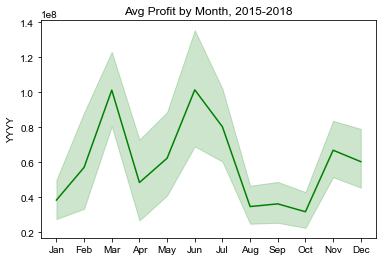

In [17]:

ax = sns.lineplot(x="month", y = "gross", data = recent_df, color="green")



ax.set_xlabel("")
ax.set_ylabel("YYYY")
ax.set_title("Avg Profit by Month, 2015-2018")
sns.set_style("whitegrid", {"grid.color": ".6","grid.linestyle":":"})

sns.set(rc={'figure.figsize':(10,5)})
sns.set_style("whitegrid", {"grid.color": ".6","grid.linestyle":":"})

A graph of profits by month indicates that the months with highest success rates tend to be early spring, early summer, and to a lesser degree, the holiday season. 

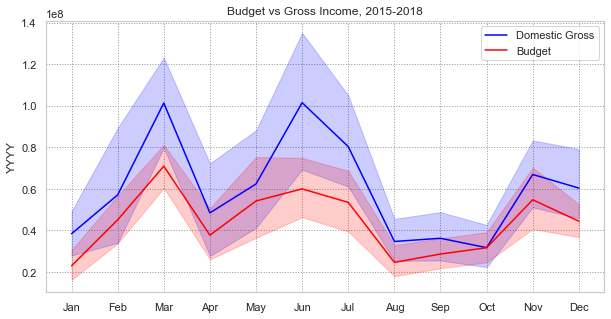

In [18]:

ax = sns.lineplot(x="month", y = "gross", data = recent_df, color="blue")
ax1 = sns.lineplot(x="month", y = "budget", data = recent_df, color = "red")


ax.set_xlabel("")
ax.set_ylabel("YYYY")
ax.set_title("Budget vs Gross Income, 2015-2018")
ax.legend(labels=["Domestic Gross","Budget"])

CONFIRM WITH SCATTER PLOT! LATER! AFTER GENRES

This graph further verifies that increased budgets behind a movie's production seem to directly effect its domestic gross income.

Next we break down these findings by Genre of movie, to see whcih of the most popular Genres tend to be more successful in general, and during which times of year.

In [19]:
recent_df['genres'].value_counts()

Drama                         91
Documentary                   52
Comedy                        35
Adventure,Animation,Comedy    32
Action,Adventure,Sci-Fi       23
                              ..
Action,Adventure,History       1
Action,Comedy,Drama            1
Fantasy,Horror                 1
Crime,Drama,Fantasy            1
Family                         1
Name: genres, Length: 192, dtype: int64

We need to break down each film by genre. If a film is listed as a Comedy and Drama ,for example, it will become two separate entries, as each genre separately.

In [20]:
#remove genre commas, and separate individual words into lists

recent_df['genres'] = recent_df['genres'].str.split(',')

In [21]:
recent_df.head()

,tconst,movie,genres,budget,gross,profit,month,year,monthNum
2875,tt6147768,Split,"[Action, Drama, Sport]",5000000,138141585,133141585,Jan,2017,1
2953,tt2869728,Ride Along 2,"[Action, Comedy, Crime]",40000000,90862685,50862685,Jan,2016,1
567,tt1109624,Paddington,"[Adventure, Comedy, Family]",55000000,76223578,21223578,Jan,2015,1
2902,tt2717822,Blackhat,"[Action, Crime, Thriller]",70000000,8005980,-61994020,Jan,2015,1
2896,tt7491090,Above and Beyond,[Documentary],1300000,288751,-1011249,Jan,2015,1


In [22]:
#separate lists of genres into new row entries

genre_df = recent_df.explode('genres')

genre_df['genres'].value_counts()

Drama          452
Comedy         232
Action         212
Adventure      167
Thriller       129
Crime          103
Horror         103
Biography      100
Documentary     82
Romance         77
Mystery         65
Sci-Fi          61
Fantasy         60
Animation       51
History         41
Family          40
Music           26
Sport           23
War             11
Musical          7
Western          3
News             1
Name: genres, dtype: int64

In [23]:
#remove lowest values, as they will skew data (everything below 50)

value_counts = genre_df['genres'].value_counts()
genre_df = genre_df[~genre_df['genres'].isin(value_counts[value_counts <= 50].index)]

In [24]:
profit_by_genre = genre_df.groupby('genres').mean()
profit_by_genre.reset_index(level=0, inplace=True)
profit_by_genre.drop('year', axis=1, inplace=True)

profit_by_genre.head()

,genres,budget,gross,profit,monthNum
0,Action,7.934410e+07,8.916209e+07,9.817991e+06,6.363208
1,Adventure,1.002797e+08,1.228922e+08,2.261242e+07,6.754491
2,Animation,8.596078e+07,1.405791e+08,5.461833e+07,6.313725
3,Biography,2.948000e+07,3.947402e+07,9.994019e+06,7.970000
4,Comedy,4.121810e+07,6.586343e+07,2.464532e+07,6.659483


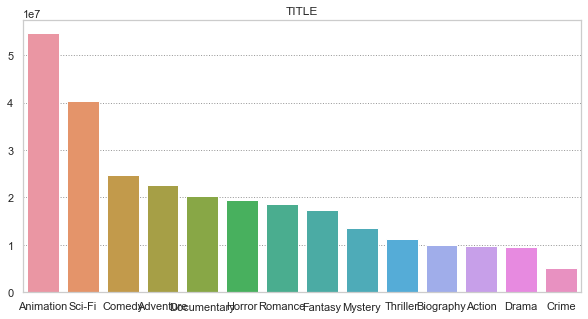

In [25]:
ax = sns.barplot(x='genres', y = "profit", data = profit_by_genre, 
                 order=profit_by_genre.sort_values('profit', ascending=False).genres)

ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("TITLE")
sns.set(rc={'figure.figsize':(15,5)})

Animation and Sci-Fi genres easily beat out the competition in terms of average profits, but it's worth looking at the most popular genres on a month-to-month basis. We'll look at the top 4.

In [36]:
animation_df = genre_df[genre_df['genres']=='Animation'].groupby('month').mean().sort_values('monthNum')
scifi_df = genre_df[genre_df['genres']=='Sci-Fi'].groupby('month').mean().sort_values('monthNum')
comedy_df = genre_df[genre_df['genres']=='Comedy'].groupby('month').mean().sort_values('monthNum')
adventure_df = genre_df[genre_df['genres']=='Adventure'].groupby('month').mean().sort_values('monthNum')

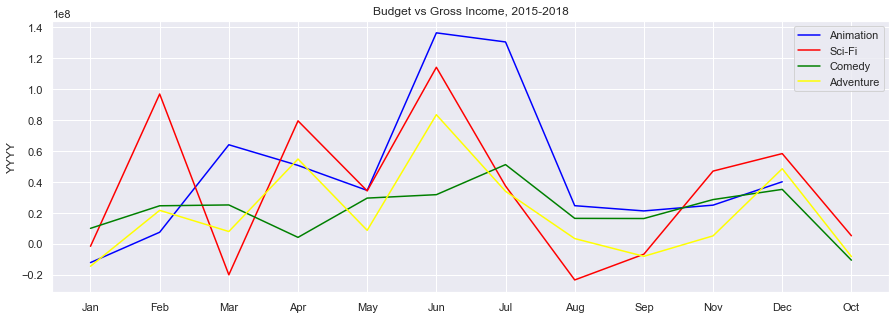

In [38]:
ax = sns.lineplot(x="month", y = "profit", data = animation_df, color="blue")
ax1 = sns.lineplot(x="month", y = "profit", data = scifi_df, color = "red")
ax2 = sns.lineplot(x="month", y = "profit", data = comedy_df, color = "green")
ax3 = sns.lineplot(x="month", y = "profit", data = adventure_df, color = "yellow")


ax.set_xlabel("")
ax.set_ylabel("YYYY")
ax.set_title("Budget vs Gross Income, 2015-2018")
ax.legend(labels=['Animation', 'Sci-Fi', 'Comedy', 'Adventure'])

after all this, using our data about profitability, pick the films with highest ratings to help inform decisions further.

add reviews column

In [29]:
reviews_df = pd.read_csv('data/zippedData/imdb.title.ratings.csv.gz')
reviews_df.head()

,tconst,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


combine the following table with existing data in a new df

## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

In [30]:
# Here you run your code to clean the data

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

In [31]:
# Here you run your code to model the data


## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***